# Demonstration 2 - IFT 3700

### Topics covered :

- Presentation of the scikit-learn library
- k-means
- How to determine $k$?
- k-means in a non-euclidean space
- Comparison of k-means, GMM and DBSCAN

### Scikit-learn library

The scikit-learn library will be very useful for us since it is dedicated to machine learning. It is a free library that contains many useful models for classification, regression, data partitioning (clustering), dimensionality reduction, etc... Instead of reinventing the wheel and reimplementing each time a classical machine learning algorithm, it is strongly recommended to use this library. Scikit-learn has been designed to be usable with other scientific libraries such as NumPy and SciPy.

NumPy is a very useful library for matrix manipulation. SciPy, which is based on NumPy, includes a large set of modules dealing with optimization, image processing, linear algebra, etc.

> **Resources:**

> The documentation of the library is complete and contains many examples, I invite you to consult it: http://scikit-learn.org/stable/

> For a basic tutorial, visit: http://scikit-learn.org/stable/tutorial/basic/tutorial.html

**tl;dr** Scikit-learn is your friend! When you can, use it instead of reimplementing everything yourself!

### Data Partitioning

Data partitioning is the process of partitioning all of our data into different groups based on distance. The aim is to minimise intra-group distance and maximise inter-group distance. The goal is to discover underlying structures in our data. However, compared to the classification problem, the problem of data partitioning is poorly defined (what is a group?). In this section, we will first look at cases where some algorithms presented during the course get bad results. Later, we will see a measure allowing us to find an appropriate number of $k$ centroids for the k-means method. Finally, we will see a modified version of k-means based on a prototype example rather than a centroid.

## k-means

Before diving into this section, here is a reminder of the k-means algorithm:

- Choose $k$ centroids randomly, ${m_1, ..., m_k}$
- Repeat if the stop condition is not met
  - Assign each point to the nearest centroid, $G_i = {x \vert \forall j \neq i, D(x, m_i) \leq D(x, m_j)}$
  - Recalculate the centroid for each group, $m_i = \frac{1}{|G_i|} \sum_{x \in G_i} x$

You can notice that there are two main steps that are similar to the expectation-maximization (EM) algorithm. First there is the E step where all the data points are assigned to a group. Then there is the M step where we determine the new centroids. These two steps are repeated until a certain stop condition is reached, e.g. a predetermined number of iterations.

To see k-means in action and try it on different datasets, I invite you to try the algorithm by yourself: https://www.naftaliharris.com/blog/visualizing-k-means-clustering/. Take the time to look at the two main steps of the algorithm.

> **Note:** for simplicity, we have chosen the initial centroids randomly. Be aware that there are other methods that allow k-means to converge faster. In scikit-learn, you can decide how this selection is made by changing the value of the parameter `init` (see the documentation of [`kMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). For example, it is possible to use the initialization technique `k-means++` which will choose distant initial centroids in order to converge faster. In general, if you want to use a modified version of an existing algorithm, take the time to look at the scikit-learn documentation. It is likely that it is possible to simply change a parameter to suit your needs!

Like any method, k-means has several assumptions *.* k-means assumes that the groups are spherical, have similar sizes and have an equivalent number of examples. When these conditions are not met, it is very likely that the method will find a local minimum and return a "bad" result. To illustrate this phenomenon, let's test k-means on data that do not respect these assumptions.


In this section, we will use the `sklearn.datasets` module that allows us to generate synthetic data. We will generate 1000 points (in two dimensions) that are sampled from three isotropic Gaussians with equal variance using the `make_blobs` method.

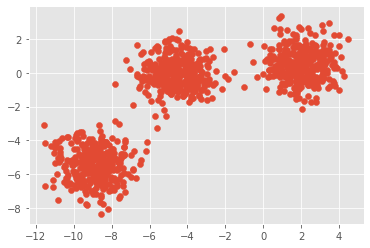

In [1]:
%matplotlib inline
# the line above allows displaying graphs in the jupyter notebook without using
# the show() method

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs\

n_samples = 1000
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)

plt.style.use('ggplot')

# We display our data. 
# As a first argument, we must provide the x-axis values, and
# as a second argument, we must provide the y-axis values
plt.scatter(x=X[:, 0], y=X[:, 1]);

Unlike the example in the last demonstration, there are no labels for each of the points. We are in an unsupervised context. Let's apply the k-means method to our data and visualize the discovered groups.

[0 0 1 1 0 1 1 2 2 1 0 2 2 2 2 2 0 0 0 2]


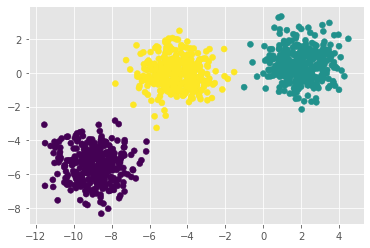

In [2]:
y_pred = KMeans(n_clusters=3).fit_predict(X)
print(y_pred[:20])
plt.scatter(X[:, 0], X[:, 1], c=y_pred);

You can see that it is very easy to apply `kMeans`. We only need to specify the `n_clusters` that corresponds to $k$ and pass the data to the `fit_predict`method. To understand what the method `fit_predict`returns, we have displayed its first 20 values. For each point, `fit_predict` returned a number that corresponds to the group determined by k-means. To view the result, we can provide this prediction as a value for the color parameter `c` to `plt.scatter`.

As these data respect sufficiently well the assumptions behind k-means, the result obtained respects our intuition. Now let's apply k-means to data that is not derived from an isotropic Gaussian.

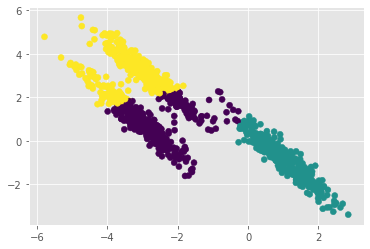

In [3]:
# Here, we apply a transformation to our data
transformation = [[0.61, -0.64], [-0.41, 0.85]]
X_aniso = np.dot(X, transformation)
 
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred);

Since the different groups are not spherical, k-means fails miserably... This time we're using data from isotropic Gaussians with very different variances.

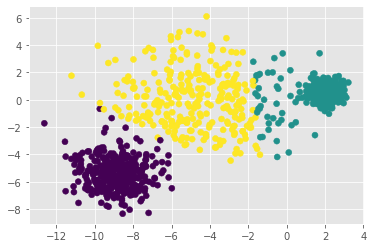

In [4]:
X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred);

Let's use data with different group sizes.

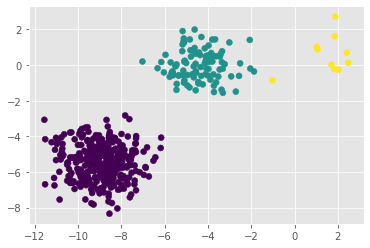

In [5]:
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,random_state=random_state).fit_predict(X_filtered)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred);

For this graph, many will find the groups suitable. However, it could also be argued that the dots on the right (yellow) do not really form a group, but rather are outliers. This illustrates the ill-defined nature of the partitioning task.

Finally, let's apply k-means to the original data, but with $k$ not corresponding to the number of Gaussians used by `make_blob`.

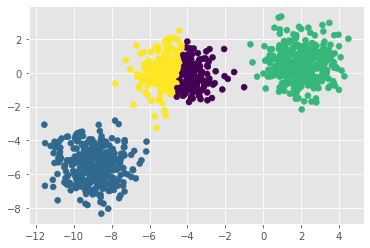

In [6]:
y_pred = KMeans(n_clusters=4).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred);

You can see that if the assumptions of the k-means method are not respected, then the results can be questionable...

## Hyperparameter: how to determine $k$?

So far we have only used two-dimensional data. It was very easy to propose a number of groups ($k$) relevant to k-means. However, in practise, most datasets have a large number of dimensions and it will not be possible to visually determine the appropriate $k$. So how do you do it?

There are several measures to assess intra-group cohesion and inter-group separation. For example, the silhouette score (<https://en.wikipedia.org/wiki/Silhouette_(clustering)>) is a score associated with each point that has a value between -1 and 1. To evaluate the partitioning, we will use the average silhouette score for all of our data. A high value means that the partitioning is adequate, conversely a low value means that the selected $k$ is inadequate.

For a point $i$, its silhouette score $s$ is given by: $$ s(i) = \frac{b(i) - a(i)}{\max{{a(i), b(i)}}} $$ where $a(i)$ is the average distance between point $i$ and all points in the same group, $b(i)$ is the average distance between point $i$ and all points not in the same group. In general, a well-assigned point will have a low $a(i)$ compared to $b(i)$.

To determine the appropriate $k$, we will apply the k-means method with different $k$ values and calculate the corresponding silhouette score for each $k$. We will choose the $k$ associated with the highest silhouette score. The silhouette score is implemented in scikit-learn, no need to implement it by ourselves!

In [7]:
from sklearn.metrics import silhouette_score

scores = []
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(X)
    scores.append(silhouette_score(X, y_pred))

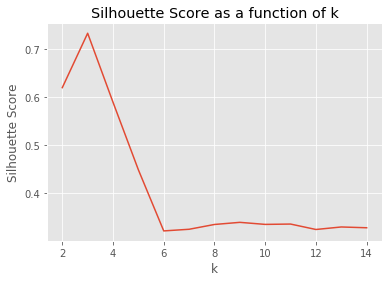

In [8]:
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score as a function of k');

For each point on the graph, we applied k-means with a different $k$. For each partitioning, the average silhouette score was calculated. As expected, the $k$ with the highest silhouette score is 3, the number of Gaussians from `make_blob`. With this data, the result is obvious. However, with "natural" data, it is often more difficult to determine the appropriate $k$. Let's try the same method with a new "mystery" dataset...

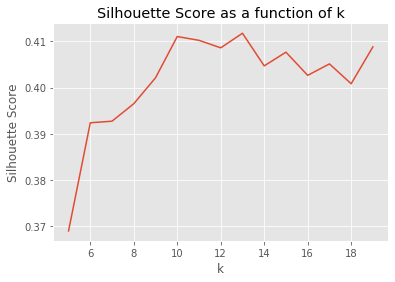

In [9]:
data_link = ('https://raw.githubusercontent.com/Cours-EDUlib/'
             'DIRO-SD1EN/master/francais/donnees/silhouette.csv')
X = pd.read_csv(data_link, delimiter=' ', header=None)
X = X.to_numpy(dtype='float64')

scores = []
k_range = range(5,20)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(X)
    scores.append(silhouette_score(X, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score as a function of k');

What is the right value of $k$? Is it 18 where the maximum is reached? Or is it 10 which has a value similar to 18, but has a lower group number? There is no definitive answer. However, the mystery dataset was in fact MNIST (the handwritten images of numbers from 0 to 9) that had undergone a dimensionality reduction. Which leads us to believe that 10 is the right answer (because there are precisely 10 classes in MNIST). However, since some numbers have different graphical representations (e.g. the number 7), it is possible that our partitioning method takes these graphs into account and considers them as groups.

Here is the partitioning obtained:

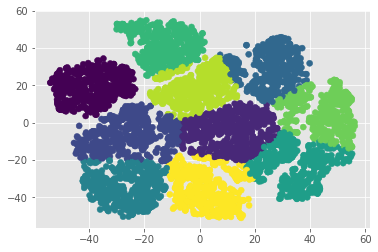

In [10]:
y_pred = KMeans(n_clusters=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred);

In general, one must be careful with this method to choose $k$. For example, if $k = |D|$ (where $D$ is the dataset), then we will get a very high score, however the discovered groups will not be relevant at all . Each data will have its own group!

Of course, there are other ways to determine the appropriate $k$. For example, some methods penalize for $k$ values that are too high. If the subject interests you, I invite you to consult: https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

## k-means in a non-euclidean space

Suppose we have data in a non-euclidean space for which we still have a notion of distance. In this case, it may be relevant to use a variant of the k-means method called k-medoids. Instead of finding a centroid to represent each of the groups, a data point will be used to represent each of the groups.

In order to illustrate k-medoids, let's take an example - a slightly artificial example - consisting of a small data set of words. Suppose these words are written by users and allow the user's language to be determined. However, users make a lot of typing errors. It is therefore not possible to simply use a dictionary (e.g. bonjour => French, hello => English). In this example, a centroid (i.e., the group average) makes no sense. Indeed, what is the middle point between "bonjour" and "hello"? The question is absurd...

In [11]:
words = ['bonjour', 'bonkour', 'bonjoru', 'bonjjour', 'bionjour', 'hello', 'helo', 'hrllo', 'ello', 'yello',
         'helllo','konnichiwa', 'konichiwa', 'konnchiwa', 'konnichioua', 'connichiwa']

But how do you assess the similarity of two words? Is "hello" closer to "apple" than it is to "shovel"? An interesting distance is the Levenshtein distance (https://en.wikipedia.org/wiki/Levenshtein_distance), which is also called editing distance. This distance between two strings is equal to the minimum number of deletions, additions and replacements necessary for the two strings to be the same. For example, between the words "*pommes*" (french for "apples") and "*assomme*" (french for "knock out") there is a Levenshtein distance of 4. Indeed, to transform "assomme" into "pomme", you must first delete the two characters "as" (2 modifications), replace the "s" for a "p" (1), then add an "s" (1). This is a total of 4 modifications.

Here we will use the python module `python-Levenshtein` to calculate the Levenshtein distance.
> **Note:** Chances are that the Levenshtein module is not installed on your computer. If this is the case, you can use the command `!pip install python-Levenshtein` below (the leading exclamation point is used to run terminal commands in the notebook):


In [12]:
!pip install python-Levenshtein

To check our example:

In [13]:
import Levenshtein
Levenshtein.distance('pommes', 'assomme')

4

Now that we have a distance to compare the words, we will be able to apply the k-medoids method. Unlike k-medoids, the implementation of k-medoids requires that we provide it with the distance matrix of our data. Each $(i,j)$ position in this matrix corresponds to the distance between example $i$ and example $j$.

In [14]:
D = np.zeros((len(words), len(words)))
for i in range(len(words)):
    for j in range(len(words)):
        D[i,j] = Levenshtein.distance(words[i], words[j])

> **Note:** Unfortunately, there is no implementation of k-medoids in scikit-learn. The implementation used here comes from https://pypi.org/project/pyclustering/0.7.0/. For the example to work, make sure you have this library installed.

In [15]:
!pip install pyclustering

In [16]:
from pyclustering.cluster.kmedoids import kmedoids

initial_medoids = [0,1,2]

# Here, we directly provide the distance matrix
# we must specify data_type='distance_matrix'
kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')

kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

In [17]:
print('Medoids:')
for i in medoids:
    print(words[i])
    
print('\nGroup partitionings:')
for label, cluster in enumerate(clusters):
    for i in cluster:
        print('label {0}:　{1}'.format(label, words[i]))

Medoids:
hello
konnichiwa
bonjour

Group partitionings:
label 0:　hello
label 0:　helo
label 0:　hrllo
label 0:　ello
label 0:　yello
label 0:　helllo
label 1:　konnichiwa
label 1:　konichiwa
label 1:　konnchiwa
label 1:　konnichioua
label 1:　connichiwa
label 2:　bonjour
label 2:　bonkour
label 2:　bonjoru
label 2:　bonjjour
label 2:　bionjour


First of all, we can see that the method returns the values of the medoids. These values correspond precisely to words with good spelling! In a second step, we can see that the different groups found correspond well to our intuition.

## Comparison of k-means to other partitioning models

We have seen several examples where the k-means method fails. Usually this happens when the data does not respect our assumptions. In this section, we will see how the Gaussian mixture and DBSCAN models perform on the same data. And, finally, we will see the limits of these two models.

### Gaussian mixture model

We have seen that k-means can have serious problems when the data are not distributed in a sphere with equal variance. In fact, this model can be seen as a special case of the Gaussian Mixture Model (GMM) where the Gaussians are isotropic (the variance of each dimension is the same and the dimensions are independent). In general, the GMM can properly partition data from non-isotropic normals.

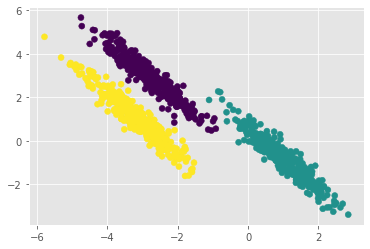

In [18]:
from sklearn.mixture import GaussianMixture

X, _ = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)
transformation = [[0.61, -0.64], [-0.41, 0.85]]
X_aniso = np.dot(X, transformation)
 
estimator = GaussianMixture(n_components=3, covariance_type='full', max_iter=20, random_state=0)
estimator.fit(X_aniso)
y_pred = estimator.predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred);

The use of `GaussianMixture` is slightly different from `kMeans`. First you have to initialize `GaussianMixture`, then use the method `fit` and finally `predict`. The difference is that `GaussianMixture` is not part of the `sklearn.cluster`module. Indeed, as you will see, this method can also be used for classification.

Now, let's use a GMM on data that does not come from a normal distribution. In this case, we will use `make_moons`.

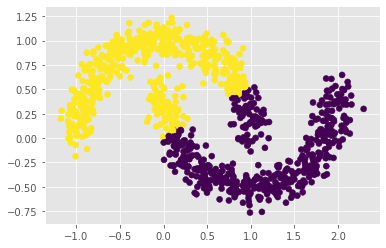

In [19]:
from sklearn.datasets import make_moons

n_samples = 1000
random_state = 170
X_moon, _ = make_moons(n_samples=n_samples, random_state=random_state, noise=0.1)

estimator = GaussianMixture(n_components=2, covariance_type='full', max_iter=20, random_state=0)
estimator.fit(X_moon)
y_pred = estimator.predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_pred);

### DBSCAN

Unlike k-means and GMM, it is not necessary to specify the number of groups expected for DBSCAN. In addition, DBSCAN does not assume any particular form of groups.

DBSCAN has two hyperparameters that can greatly influence the result obtained: the neighborhood radius and the critical density.

To test for yourself: https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

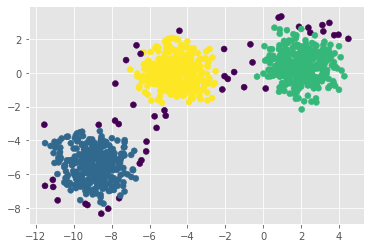

In [20]:
from sklearn.cluster import DBSCAN

y_pred = DBSCAN().fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred);

The use of `DBSCAN` is almost identical to `kMeans`: just use the method `fit_predict`. We did not specify a value for the hyperparameters. These values are by default `eps=0.5, min_samples=5`, i.e. a radius of 0.5 and a critical density.

On these data, the result is similar to k-means. However, DBSCAN has - as a bonus - identified outliers.

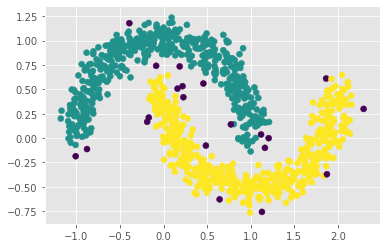

In [21]:
y_pred = DBSCAN(eps=0.1, min_samples=5).fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_pred);

Since DBSCAN has no *preconceptions* about the form of the data distribution, the `make_moons` dataset is not a problem. Now let's apply DBSCAN to the same data where k-means failed:

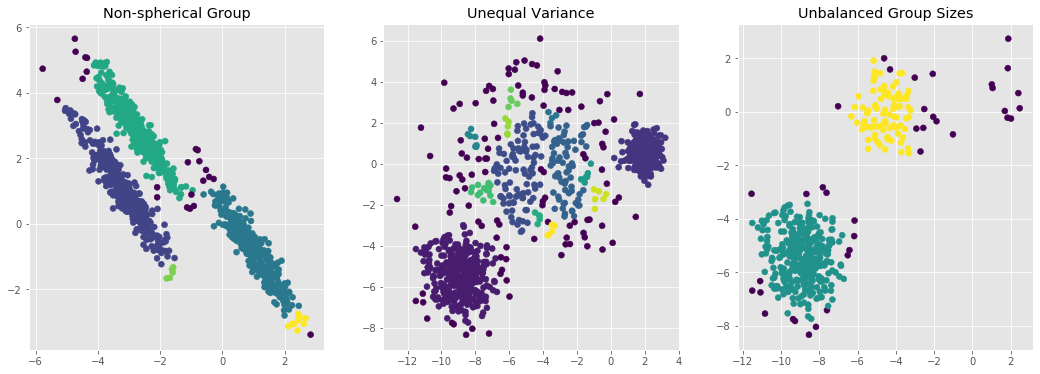

In [22]:
plt.figure(figsize=(18, 6))

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=0.3, min_samples=5).fit_predict(X_aniso)

plt.subplot(131)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Non-spherical Group")

X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = DBSCAN().fit_predict(X_varied)

plt.subplot(132)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = DBSCAN().fit_predict(X_filtered)

plt.subplot(133)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unbalanced Group Sizes");

Here we used `subplot` which can be very handy to display several graphs at the same time.

Finally, let's apply DBSCAN to non-isotropic Gaussians, but with different hyperparameters .

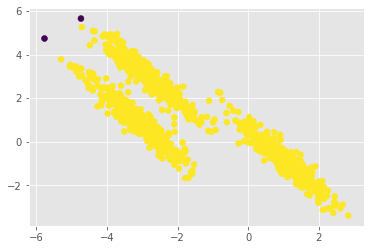

In [23]:
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred);

Here, the neighborhood radius (`eps` in the code) is too large and all the data is grouped into one large group.

## Conclusion

To summarize this demonstration, we have seen that each method has its weak and strong points. It is important to take this into account when using them! We have seen a modified version of k-means to handle data that are not in a Euclidean space. We have also seen a method to find the best hyperparameter  $k$ for our k-means method. In addition, throughout the demonstration, we became familiar with the great library scikit-learn!

(Examples from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html)

# Exercises

1. As the objective of k-means is non-convex, this algorithm often returns local minima: i.e. partitionings that are not optimal. However, in practice, this is not a major problem, because the algorithm is applied several times with different _seeds_ . To highlight the phenomenon of local minima, use the data `X` below, set the argument `init` from `kMeans` to `'random'` and change an argument from `kMeans` to use a single _seed_ (Refer to the documentation). Apply the algorithm several times and display the different partitionings found by `kMeans`. See how the results can vary widely...

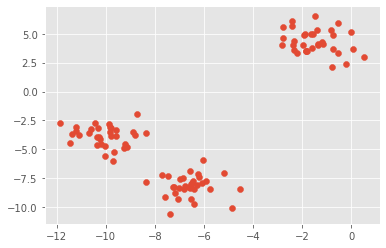

In [24]:
n_samples = 100
random_state = 1
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)
plt.scatter(x=X[:, 0], y=X[:, 1]);

### Solution 1.

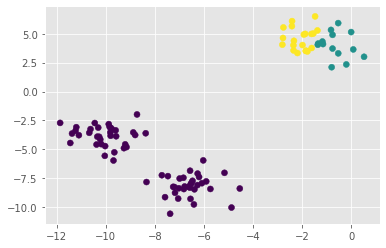

In [25]:
y_pred = KMeans(n_clusters=3, init="random", n_init=1, random_state=5).fit_predict(X)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y_pred);

This first exercise had two objectives. On the one hand, getting used to consulting the scikit-learn documentation which will be very useful for the rest of the course. On the other hand, to show the phenomenon of convergence to a local minimum. We can see that although the partitioning problem seems easy (there are three distinct groups), some initializations lead to poor results. In future courses you will see other methods that can converge to local minima. Keep in mind that different initializations can give very different results!

2. Find values of `epsilon` and `min_samples` for the DBSCAN algorithm that return a "good partitioning" of the data `X` here (data from a scikit-learn example), i.e. 4 clusters. You can test by trial-and-error or use the `OPTICS` method.

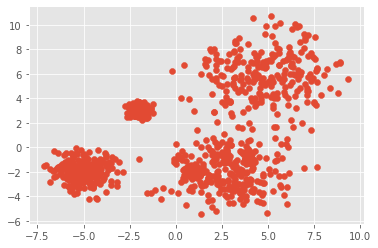

In [26]:
np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))
plt.scatter(X[:,0], X[:,1]);

### Solution 2.

The OPTICS method is similar to DBSCAN, but it helps find a good epsilon value. To begin with, let's try to apply the method directly.

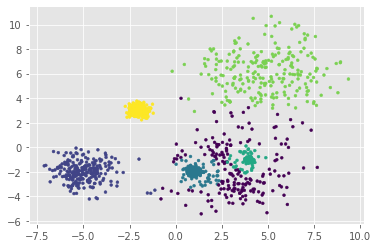

In [27]:
from sklearn.cluster import OPTICS

clust = OPTICS(min_samples=50, max_eps=10)
y_pred = clust.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=8);

The result is not convincing. The source of the problem is clear: the density is not at all uniform. Within one of the clusters, there are two other very dense clusters. OPTICS allows us to see the different partitionings according to the epsilon value. Let's reapply OPTICS and find a good epsilon value.

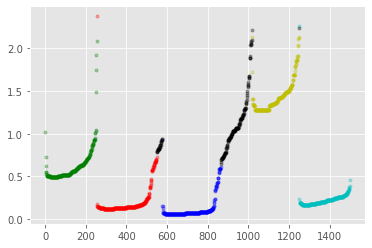

In [28]:
from sklearn.cluster import OPTICS

clust = OPTICS(min_samples=50, max_eps=10)
clust.fit(X)

space = np.arange(X.shape[0])
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3);

To understand this graph, here is a brief explanation of OPTICS. OPTICS has two hyperparameters: `min_samples` which corresponds to the critical density and `max_eps` which corresponds to the maximum radius that will be considered. A dot is considered a midpoint if its `core distance` is smaller than `max_eps`. The `core distance` of a certain point is the minimum radius necessary for that point to have at least `min_samples` neighbors. The `reachability distance` from a $p$ point to a $q$ midpoint is the minimum radius to include $p$ as a neighbor of $q$ and for $q$ to have at least `min_samples` neighbors. In other words, it is $max(core \ distance(q), distance(p,q))$. Now that these concepts have been explained, let's analyze the graph. The x-axis is the order of the points in which the algorithm propagated and the y-axis is the `reachability distance` of each point. You can see several "valleys". These valleys correspond to clusters. Indeed, when the value of `reachability distance` is low for several points, it means that the points are all close to each other and form a cluster. With the help of the graph, we can see that by taking an epsilon of 2 (or about 1.5 to 2), we will be able to find the clusters that interest us. If we choose an epsilon too low, for example 1, the whole yellow cluster will be considered as noise (because this cluster is not very dense).

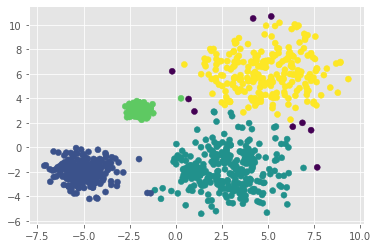

In [29]:
from sklearn.cluster import DBSCAN

y_pred = DBSCAN(eps=2, min_samples=50).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred);

We can see that an epsilon of 2 does indeed give a good result. The advantage of OPTICS over the test-error method is that the OPTICS method only had to be applied once to determine the epsilon value. Of course, this method does not solve all the problems: a critical density and maximum epsilon must still be provided.

> __Note:__ As this method has not been presented in the course and my explanations are intended to be brief, it will not be subject to review.

3. Determine the number of clusters in a real dataset by using the k-means algorithm and the silhouette score. We can download it using `sklearn.datasets.load_breast_cancer`. This dataset contains breast tumor biopsy results. Use the following lines to get the data (make sure you have downloaded the dataset and put it in the same folder as your notebook).

In [30]:
import pandas as pd
from sklearn import datasets

X = datasets.load_breast_cancer().data

### Solution 3.

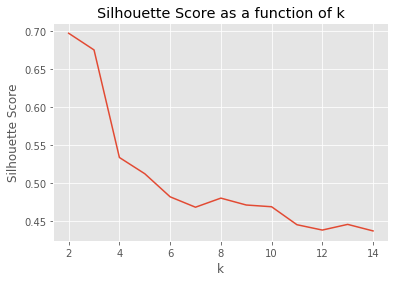

In [31]:
scores = []
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(X)
    scores.append(silhouette_score(X, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score as a function of k');

According to the graph, the correct number of partitions according to $k$ seems to be 2. However, according to the medical literature, we often talk about 4 types of breast cancer. Certainly, our graph seems, to a small extent, to confirm this: we see a plateau in the score for $k = [3.5]$. But how do you explain that it's not more obvious? There are certainly several possible explanations. Among other things, this may be because of the data that we use. For example, the data may be too noisy or the type of data (biopsy) may not give enough information to distinguish between types of cancer. In short, this exercise shows you that, although partition index scores are useful, they are quite limited and should not be relied upon blindly. Moreover, unlike the synthetic examples, it is not easy to draw conclusions. Among other things, it is not possible to directly visualize the results since they are in 9 dimensions.